# Getting the data

Data file row

    0024  J020329.86-091020.3 666-52149-109   2000        3      Certain

## SDSS

Look up SDSS spectrum IDs by coordinates:

* http://skyserver.sdss.org/dr15/en/home.aspx
* go to navigate
* enter coordinates
* go to explore
* find FITS file URL

Get a single spectrum from SDSS

    $ wget https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/0666/spec-0666-52149-0109.fits
    $ wget http://dr15.sdss.org/sas/dr15/eboss/spectro/redux/v5_10_0/spectra/5743/spec-5743-56011-0077.fits
    
How to read the files

    http://classic.sdss.org/dr7/products/spectra/read_spSpec.html
    
What's in the files
    
    http://classic.sdss.org/dr7/products/spectra/
    
## Galex

To get a list of all files, use MAST SQL Search 

    http://galex.stsci.edu/GR6/?page=sqlform

with the following query

    SELECT fuv_filename, nuv_filename FROM SPECEXTRACT
    
Output is written to `data/galex_all.csv`, to extract tile names only, run

    $ cat galex_all.csv | cut -d',' -f 1 | grep -oP '[^/]+-[a-z]+-[a-z]+.fits' | grep -oP '^[^-]+' > galex_all.txt
    
Figure out the actual URL of the FITS file. Let's assume tile name is `GI3_104005_J020329m091020`

    $ cat galex_all.csv | grep GI3_104005_J020329m091020 | cut -d',' -f 1 | grep -oP '01-vsn[\w/-]+\.fits'
    
Replace `-gsax` with `-gsp` and the `-fg-` part with `-ng-` to get nuv part of spectrum.

Find spectra in Galex, specify Ra, Dec in sexagesimal format, e.g. 02:03:29.86, -09:10:20.3

    http://galex.stsci.edu/GR6/?page=tilelist&survey=spectra&showall=Y
    
Data format

    http://www.galex.caltech.edu/DATA/gr1_docs/GR1_Pipeline_and_advanced_data_description_v2.htm

Grab the fits file

    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-ng-gsp.fits.gz
    
    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-fg-gsp.fits.gz
    


In [1]:
%pylab inline

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


## Coordinate conversion

In [3]:
c = SkyCoord.from_name('J100110.2+552834')
c

<SkyCoord (ICRS): (ra, dec) in deg
    (150.2926, 55.4762)>

# Load and plot an SDSS spectrum

Note, that these are sky-subtracted but not corrected for foreground extinction.

In [4]:
sdss = fits.open('../data/sdss/fits/spec-5743-56011-0077.fits')
spec = sdss[1]
info = sdss[2]

[2.0972316]


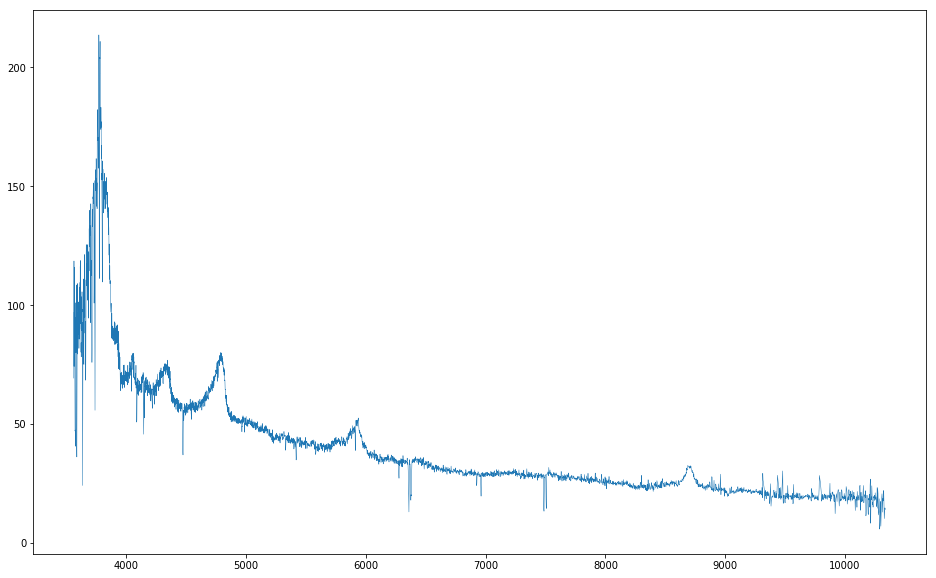

In [5]:
z = info.data['Z']
wl_sdss = 10**spec.data['loglam']
fl_sdss = spec.data['flux']

figsize(16, 10)
plot(wl_sdss, fl_sdss, lw=0.5)
print(z)

# Load and plot a Galex spectrum

In [6]:
#fuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-fg-gsp.fits.gz')
#nuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-ng-gsp.fits.gz')

#fuv = fits.open('../data/galex/fits/GI1_085032_NGC3079-fg-xsp.fits.gz')
#nuv = fits.open('../data/galex/fits/GI1_085032_NGC3079-ng-xsp.fits.gz')

fuv = fits.open('../data/galex/fits/GI1_033007_NGC3079-xg-gsp.fits.gz')

In [7]:
fuv[1].data.columns

ColDefs(
    name = 'ggoid'; format = '2J'; unit = 'number'
    name = 'ggoid_D'; format = '2J'; unit = 'number'
    name = 'band'; format = '1J'; unit = 'number'
    name = 'id'; format = '1J'; unit = 'number'
    name = 'alpha_j2000'; format = '1D'; unit = 'degrees'
    name = 'delta_j2000'; format = '1D'; unit = 'degrees'
    name = 'nuv_nc'; format = '1J'; unit = 'number'
    name = 'nuv_nr'; format = '1J'; unit = 'number'
    name = 'nuv_mag'; format = '1E'; unit = 'magnitude'
    name = 'nuv_detx'; format = '1E'; unit = 'pixel'
    name = 'nuv_dety'; format = '1E'; unit = 'pixel'
    name = 'nuv_Q'; format = '1E'; unit = 'value'
    name = 'nuv_mid_detx'; format = '1E'; unit = 'pixel'
    name = 'nuv_mid_dety'; format = '1E'; unit = 'pixel'
    name = 'nuv_mid_Q'; format = '1E'; unit = 'value'
    name = 'nuv_mid_ra'; format = '1D'; unit = 'degrees'
    name = 'nuv_mid_dec'; format = '1D'; unit = 'degrees'
    name = 'fuv_nc'; format = '1J'; unit = 'number'
    name = 'fuv_nr'; f

## Find closest object

In [14]:
print(c)
ra_all = fuv[1].data['alpha_j2000']
dec_all = fuv[1].data['delta_j2000']
idx = np.where(np.abs(ra_all - c.ra.value) < 1./3600.)
print(idx)
idx = idx[0][0]
ra = ra_all[idx]
dec = dec_all[idx]
print(ra, dec)

<SkyCoord (ICRS): (ra, dec) in deg
    (150.2926, 55.4762)>
(array([80], dtype=int64),)
150.2928237624488 55.47630947465953


# Figure out wavelength grid

In [15]:
print(fuv[1].data['zero'][idx])
print(fuv[1].data['disp'][idx])

1300.0
3.5


-999.0


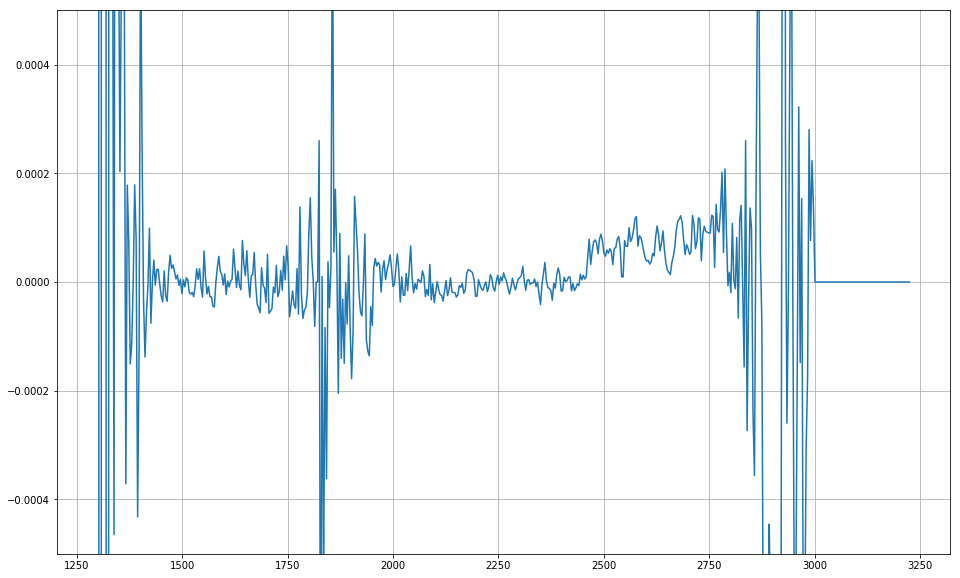

In [16]:
z = fuv[1].data['redshift'][idx]
fl_fuv = fuv[1].data['obj'][idx]
wl_fuv = fuv[1].data['zero'][idx] + fuv[1].data['disp'][idx] * np.linspace(0, fl_fuv.shape[0] - 1, fl_fuv.shape[0])

#fl_nuv = nuv[1].data['obj'][idx]
#wl_nuv = nuv[1].data['zero'][idx] + nuv[1].data['disp'][idx] * np.linspace(0, fl_nuv.shape[0] - 1, fl_nuv.shape[0])

print(z)

figsize(16, 10)
grid(True)
ylim(-0.0005, 0.0005)
plot(wl_fuv, fl_fuv)
#plot(wl_nuv, fl_nuv)

## Figure out flux unit conversion

Nice conversion chart:

    https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf


* SDSS is in $10^{-17}$ erg/sec/cm$^{2}$/A
* Galex is in photon/sec/cm$^{2}$/A

In [17]:
#fl_nuv_c = 1.99e-8 * 1e17 * fl_nuv / wl_nuv
fl_fuv_c = 1.99e-8 * 1e17 * fl_fuv / wl_fuv

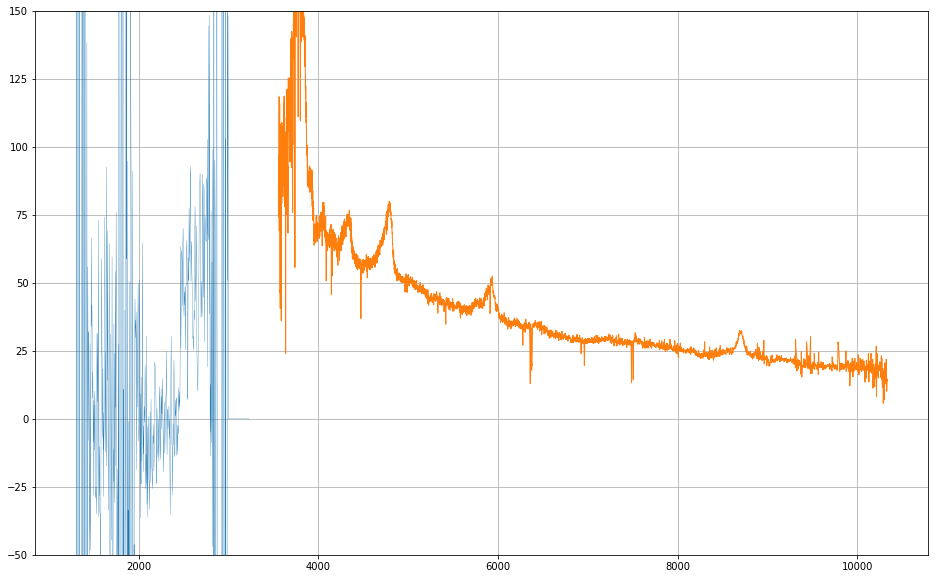

In [21]:
figsize(16, 10)
grid(True)
ylim(-50, 150)
plot(wl_fuv, fl_fuv_c, lw=0.3)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
plot(wl_sdss, fl_sdss, lw=1)

(6200, 6500)

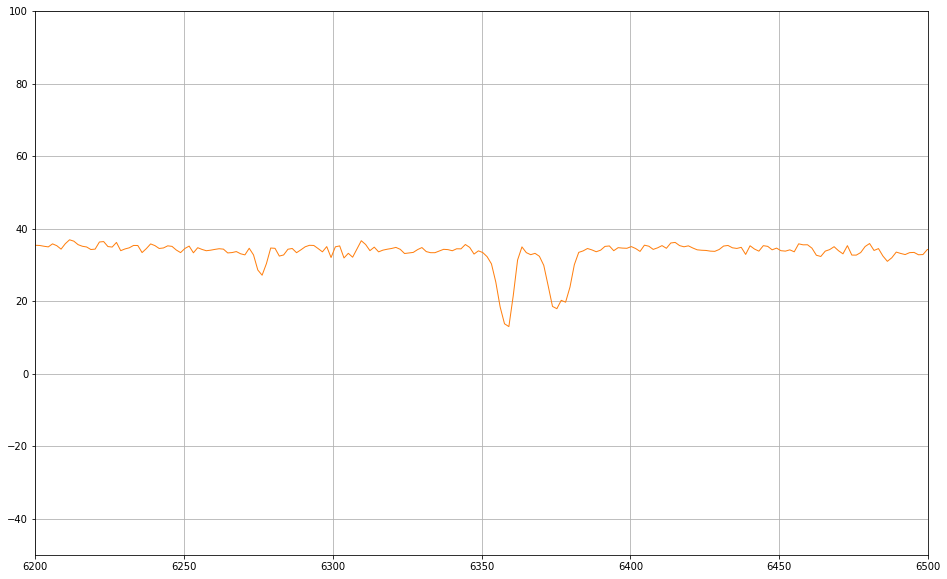

In [22]:
figsize(16, 10)
grid(True)
ylim(-50, 100)
plot(wl_fuv, fl_fuv_c, lw=0.3)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
plot(wl_sdss, fl_sdss, lw=1)
xlim(6200,6500)

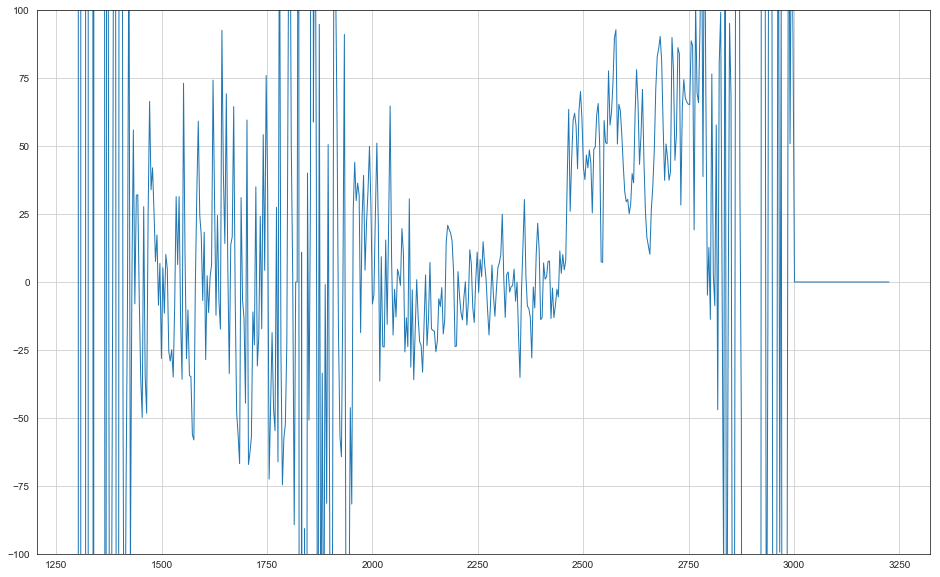

In [42]:
figsize(16, 10)
grid(True)
ylim(-100, 100)
plot(wl_fuv, fl_fuv_c, lw=1)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
#plot(wl_sdss, fl_sdss, lw=1)

# Testing necessary packages

Install packages directly from github

    # pip install git+https://github.com/linetools/linetools.git
    # pip install git+https://github.com/pyigm/pyigm.git


In [28]:
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass

from linetools.spectra.xspectrum1d import XSpectrum1D
from pyigm.abssys import utils as igmau
from pyigm.abssys.lls import LLSSystem

In [69]:
# Compute the model in restframe
z = 0.0
lls = LLSSystem((0.*u.deg, 0.*u.deg), z, None, NHI=17.9)
lls

<LLSSystem: J000000+000000_z0.000000 00:00:00 +00:00:00, zabs=0, logNHI=17.9, tau_LL=5.03538, [Z/H]=0 dex>

In [70]:
lls.fill_lls_lines()

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


C:\ProgramData\Anaconda3\lib\site-packages\linetools\isgm\abscomponent.py:737: UserWarning: Absline <AbsLine: HI 912d, z=0.0000 wrest=912.7032 Angstrom, f=5.264e-05> has flag=0.  Hopefully you expected that
  warnings.warn("Absline {} has flag=0.  Hopefully you expected that".format(str(aline)))
C:\ProgramData\Anaconda3\lib\site-packages\linetools\isgm\abscomponent.py:737: UserWarning: Absline <AbsLine: HI 912e, z=0.0000 wrest=912.7676 Angstrom, f=5.812e-05> has flag=0.  Hopefully you expected that
  warnings.warn("Absline {} has flag=0.  Hopefully you expected that".format(str(aline)))
C:\ProgramData\Anaconda3\lib\site-packages\linetools\isgm\abscomponent.py:737: UserWarning: Absline <AbsLine: HI 912f, z=0.0000 wrest=912.8389 Angstrom, f=6.435e-05> has flag=0.  Hopefully you expected that
  warnings.warn("Absline {} has flag=0.  Hopefully you expected that".format(str(aline)))
C:\ProgramData\Anaconda3\lib\site-packages\linetools\isgm\abscomponent.py:737: UserWarning: Absline <AbsLine:

In [75]:
# create a wavelength grid from scratch
wave = np.arange(200., 2000)

# use the wavelength grid from galex
# but it should be redshifted!
# wave = wl_fuv

npix = len(wave)
spec = XSpectrum1D.from_tuple((wave*u.AA,np.ones(npix)))

Let's try to find the redshift of the LLS by hand

C:\ProgramData\Anaconda3\lib\site-packages\linetools\analysis\voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
C:\ProgramData\Anaconda3\lib\site-packages\linetools\analysis\voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
C:\ProgramData\Anaconda3\lib\site-packages\linetools\analysis\voigt.py:229: UserWarning: Rebinned tau back to your input array.  Reconsider input
  warnings.warn('Rebinned tau back to your input array.  Reconsider input')


(1900, 3000)

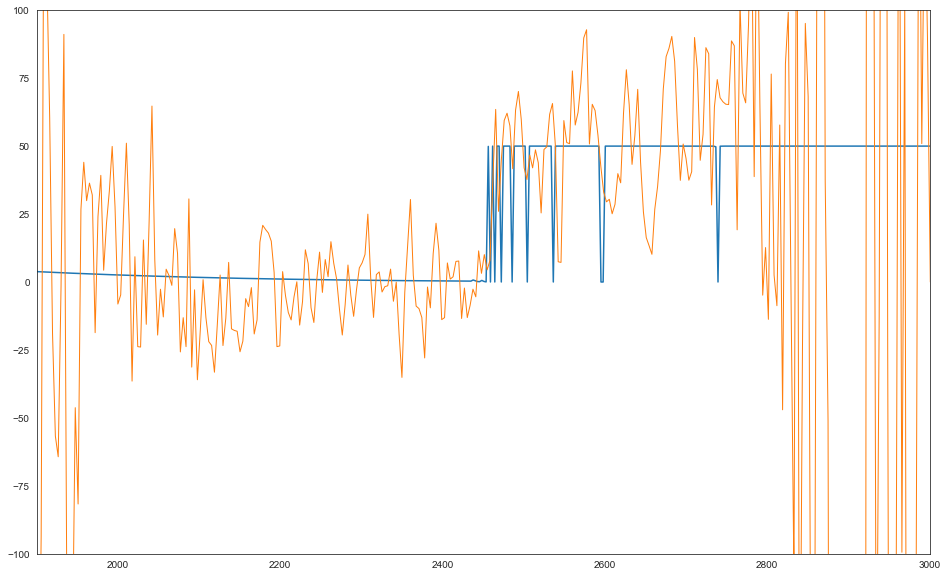

In [86]:
model = lls.flux_model(spec)
#model.plot()

plot(wave * (1 + 1.6), model.flux * 50)
plot(wl_fuv, fl_fuv_c, lw=1)
ylim(-100, 100)
xlim(1900, 3000)